In [4]:
import jax.numpy as jnp
import jax
from fbpinns.problems import Problem

class Schrodinger1D(Problem):
    """
    Solves the 1D time-dependent Schrödinger equation:

         i ψ_t = -½ ψ_{xx} + |ψ|² ψ,

    where the complex wavefunction ψ is split into real and imaginary parts:
         ψ(x,t) = u(x,t) + i v(x,t).

    This leads to a coupled system of two real PDEs:
    
         - v_t + ½ u_{xx} + (u² + v²) u = 0,   (Equation 1)
         u_t + ½ v_{xx} + (u² + v²) v = 0.      (Equation 2)
    
    The initial condition is chosen to be the ground state of the harmonic oscillator:
    
         ψ(x,0) = ψ₀(x) = 2sech(x) = 2/cosh(x)
    
    so that u(x,0) = ψ₀(x) and v(x,0) = 0.
    
    The spatial domain is chosen as x ∈ [-L, L] (with L sufficiently large so that ψ ≈ 0 at x = ±L)
    and time t ∈ [0, T].
    """

    @staticmethod
    def init_params(omega=1.0, L=5.0, sd=0.1):
        # Define the dimensionality:
        #   ud = 2 (u, v)
        #   xd = 2 (x, t)
        static_params = {
            "dims": (2, 2),
            "omega": omega,
            "L": L,
            "sd": sd
        }
        return static_params, {}

    @staticmethod
    def sample_constraints(all_params, domain, key, sampler, batch_shapes):
        x_batch = domain.sample_interior(all_params, key, sampler, batch_shapes[0])
        
        # For the two equations, we need the following derivatives:
        # For Equation (1): we require u, u_{xx} and v_t.
        # For Equation (2): we require v, v_{xx} and u_t.
        required_diffs = (
            (0, ()),     # u
            (0, (0, 0)), # u_xx
            (1, (1,)),   # v_t
            (1, ()),     # v
            (1, (0, 0)), # v_xx
            (0, (1,)),   # u_t
        )
        return [[x_batch, required_diffs],]

    @staticmethod
    def constraining_fn(all_params, x_batch, net_out):
        """
        Enforces both the initial condition and the boundary conditions.
        """

        x = x_batch[:, 0:1]
        t = x_batch[:, 1:2]
        omega = all_params["static"]["problem"]["omega"]
        L = all_params["static"]["problem"]["L"]
        sd = all_params["static"]["problem"]["sd"]
        tanh = jax.nn.tanh
        
        # Constraining function
        c = tanh((L+x)/sd) * tanh((L-x)/sd)
        
        # Define the initial condition (ground state of the harmonic oscillator)
        psi0 = 2.0/jnp.cosh(x)
        
        # Split the raw network output into its two components.
        u = net_out[:, 0:1]
        v = net_out[:, 1:2]
        
        # Reparameterize to enforce the conditions.
        u = c * t * u + psi0
        v = c * t * v
        # Concatenate u and v to form the full two-component output.
        return jnp.concatenate([u, v], axis=1)

    @staticmethod
    def loss_fn(all_params, constraints):
        """
        Computes the physics residual for both equations:
        
        The loss is defined as the sum of the mean squared errors of the residuals for
        both equations.
        """
        omega = all_params["static"]["problem"]["omega"]
        x_batch, u, uxx, vt, v, vxx, ut = constraints[0]
        
        x = x_batch[:, 0:1]
        
        # res1 = -vt + 0.5 * uxx - 0.5 * omega**2 * (x**2) * u
        # res2 = ut + 0.5 * vxx - 0.5 * omega**2 * (x**2) * v
        res1 = -vt + 0.5 * uxx + (u**2 + v**2) * u
        res2 = ut + 0.5 * vxx + (u**2 + v**2) * v
        
        loss1 = jnp.mean(res1**2)
        loss2 = jnp.mean(res2**2)
        return loss1 + loss2, res1 + res2

    @staticmethod
    def exact_solution(all_params, x_batch, batch_shape=None):
        """
        No closed form exact solution. Returns zeros.
        """
        # omega = all_params["static"]["problem"]["omega"]
        # x = x_batch[:, 0:1]
        # t = x_batch[:, 1:2]
        # sech = lambda z: 1.0/jnp.cosh(z)
        # u = omega * sech(omega * x) * jnp.cos( (omega**2 * t)/2.0 )
        # v = omega * sech(omega * x) * jnp.sin( (omega**2 * t)/2.0 )
        # return jnp.zeros_like(jnp.concatenate([u, v], axis=1))

        x = x_batch[:, 0:1]          # spatial coordinate
        t = x_batch[:, 1:2]          # time coordinate

        sech = lambda z: 1.0 / jnp.cosh(z)

        u = 2.0 * sech(x) * jnp.cos(2.0 * t)
        v = 2.0 * sech(x) * jnp.sin(2.0 * t)

        return jnp.concatenate([u, v], axis=1)


In [5]:
import jax.numpy as jnp
import jax
from fbpinns.problems import Problem

class Schrodinger1D_(Problem):
    """
    Focusing 1‑D cubic nonlinear Schrödinger equation (NLS):

        i ψ_t + ½ ψ_{xx} + |ψ|² ψ = 0,     ψ = u + i v.

    Split into coupled real PDEs:

        - v_t + ½ u_{xx} + (u² + v²) u = 0,
          u_t + ½ v_{xx} + (u² + v²) v = 0.

    Initial profile (bright soliton of unit speed & amplitude 2):

        ψ(x,0) = 2 sech(x)     ⇒     u(x,0)=2 sech(x),  v(x,0)=0.

    Domain: x ∈ [-L, L], t ∈ [0, T].  On the finite interval
    we enforce ψ ≈ 0 at x = ±L by a smooth spatial taper `c(x)`
    that vanishes at the boundaries and is ≈1 in the interior.
    """

    @staticmethod
    def init_params(L: float = 5.0, sd: float = 0.1):
        """
        Parameters
        ----------
        L  : half‑width of the spatial domain (x ∈ [-L, L]).
        sd : width of the tanh "switch" that imposes decay at |x|≈L.
        """
        static_params = {
            "dims": (2, 2),   # (output dimension u,v , input dimension x,t)
            "L": L,
            "sd": sd,
        }
        return static_params, {}

    @staticmethod
    def sample_constraints(all_params, domain, key, sampler, batch_shapes):
        """
        Draw interior collocation points together with the list of
        field components / derivatives that the network must return.
        """
        x_batch = domain.sample_interior(all_params, key, sampler, batch_shapes[0])

        required_diffs = (
            (0, ()),      # u
            (0, (0, 0)),  # u_xx
            (1, (1,)),    # v_t
            (1, ()),      # v
            (1, (0, 0)),  # v_xx
            (0, (1,)),    # u_t
        )
        return [[x_batch, required_diffs],]

    @staticmethod
    def constraining_fn(all_params, x_batch, net_out):
        """
        Apply boundary and initial conditions by re‑parametrising
        the raw network output (û,v̂) → (u,v).

        The taper   c(x) = tanh((L+x)/sd) tanh((L-x)/sd)
        satisfies   c(±L)=0  and  c≈1 for |x|≪L.

        We enforce ψ(x,0)=2 sech x exactly and gradually blend
        the network output in time so that
               ψ(x,t) = ψ₀(x) + c(x) t (û + i v̂).
        """
        x = x_batch[:, 0:1]
        t = x_batch[:, 1:2]
        L = all_params["static"]["problem"]["L"]
        sd = all_params["static"]["problem"]["sd"]

        c = jax.nn.tanh((L + x) / sd) * jax.nn.tanh((L - x) / sd)

        psi0_real = 2.0 / jnp.cosh(x)  # u(x,0)
        psi0_imag = 0.0                # v(x,0)

        u_net = net_out[:, 0:1]
        v_net = net_out[:, 1:2]

        u = psi0_real + c * t * u_net
        v = psi0_imag + c * t * v_net

        return jnp.concatenate([u, v], axis=1)

    @staticmethod
    def loss_fn(all_params, constraints):
        """
        Physics‑based residual for the two real PDEs.
        """
        x_batch, u, uxx, vt, v, vxx, ut = constraints[0]

        res1 = -vt + 0.5 * uxx + (u**2 + v**2) * u  # Eqn for u
        res2 =  ut + 0.5 * vxx + (u**2 + v**2) * v  # Eqn for v

        return jnp.mean(res1**2) + jnp.mean(res2**2), res1 + res2

    @staticmethod
    def exact_solution(all_params, x_batch, batch_shape=None):
        """
        Closed‑form bright‑soliton solution that matches the IC:

            ψ(x,t) = 2 sech(x) e^{i 2 t}
        """
        x = x_batch[:, 0:1]
        t = x_batch[:, 1:2]

        sech = lambda z: 1.0 / jnp.cosh(z)

        u = 2.0 * sech(x) * jnp.cos(2.0 * t)
        v = 2.0 * sech(x) * jnp.sin(2.0 * t)

        return jnp.concatenate([u, v], axis=1)

[INFO] 2025-06-05 15:27:26 - <fbpinns.constants.Constants object at 0x7029a9976bd0>
run: test
domain: <class 'fbpinns.domains.RectangularDomainND'>
domain_init_kwargs: {'xmin': array([-8.,  0.]), 'xmax': array([8.        , 1.57079633])}
problem: <class '__main__.Schrodinger1D_'>
problem_init_kwargs: {'L': 8.0}
decomposition: <class 'fbpinns.decompositions.RectangularDecompositionND'>
decomposition_init_kwargs: {'subdomain_xs': [array([-8.        , -7.15789474, -6.31578947, -5.47368421, -4.63157895,
       -3.78947368, -2.94736842, -2.10526316, -1.26315789, -0.42105263,
        0.42105263,  1.26315789,  2.10526316,  2.94736842,  3.78947368,
        4.63157895,  5.47368421,  6.31578947,  7.15789474,  8.        ]), array([0.        , 0.39269908, 0.78539816, 1.17809725, 1.57079633])], 'subdomain_ws': [array([2.44210526, 2.44210526, 2.44210526, 2.44210526, 2.44210526,
       2.44210526, 2.44210526, 2.44210526, 2.44210526, 2.44210526,
       2.44210526, 2.44210526, 2.44210526, 2.44210526, 2.

[INFO] 2025-06-05 15:27:26 - Total number of trainable parameters:
[INFO] 2025-06-05 15:27:26 - 	attention: 40,000
[INFO] 2025-06-05 15:27:26 - 	problem: 1
[INFO] 2025-06-05 15:27:26 - 	network: 8,000
[INFO] 2025-06-05 15:27:26 - Total number of constraints: 1
[INFO] 2025-06-05 15:27:26 - Computing exact solution..
[INFO] 2025-06-05 15:27:26 - Computing done
[INFO] 2025-06-05 15:27:26 - Getting test data inputs..
[INFO] 2025-06-05 15:27:26 - [i: 0/50000] Updating active inputs..
[INFO] 2025-06-05 15:27:27 - [i: 0/50000] Average number of points/dimension in active subdomains: 55.12
[INFO] 2025-06-05 15:27:27 - [i: 0/50000] Updating active inputs done (0.04 s)
[INFO] 2025-06-05 15:27:27 - [i: 0/50000] Compiling update step..
[INFO] 2025-06-05 15:27:27 - x_batch
[INFO] 2025-06-05 15:27:27 - (40000, 2), float32, JVPTracer
[INFO] 2025-06-05 15:27:27 - x_take
[INFO] 2025-06-05 15:27:27 - (303772, 2), float32, JVPTracer
[INFO] 2025-06-05 15:27:27 - x_batch
[INFO] 2025-06-05 15:27:27 - (40000

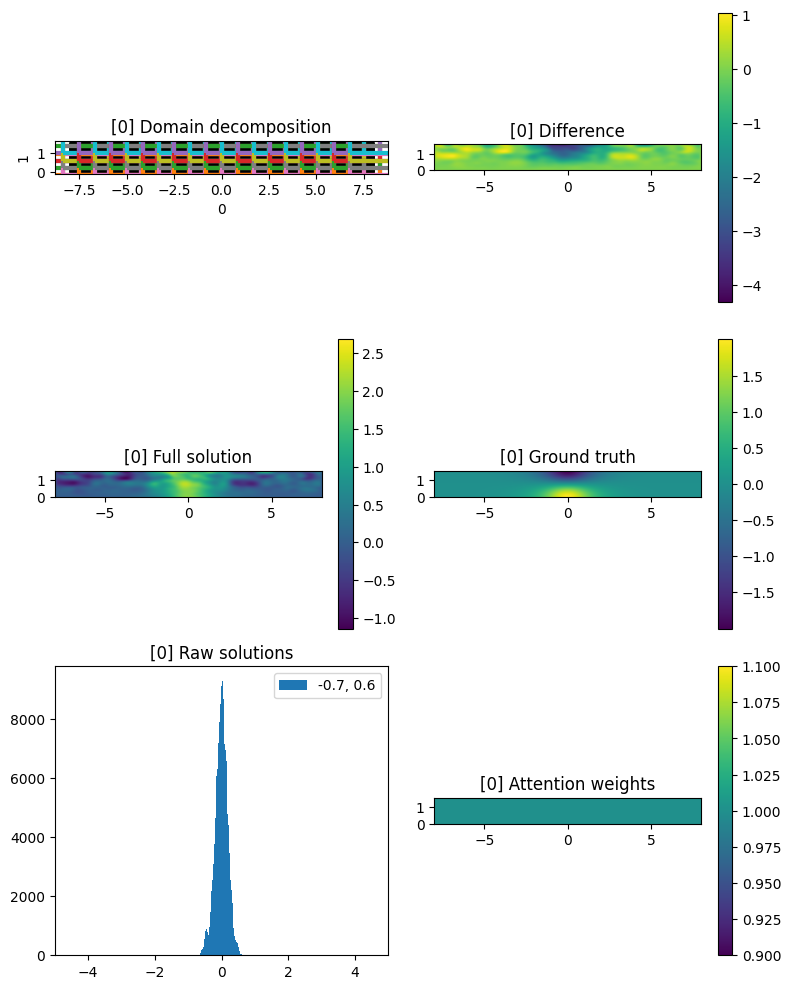

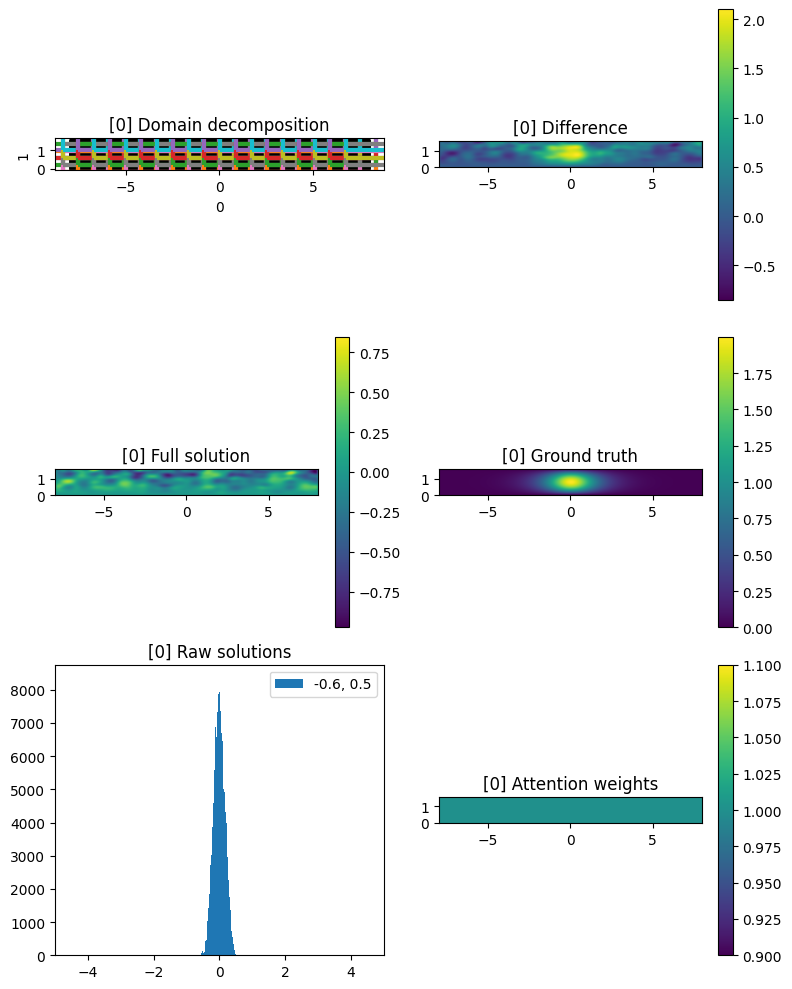

[INFO] 2025-06-05 15:27:48 - [i: 1000/50000] loss: 0.0278 rate: 49.8 elapsed: 0.01 hr test
[INFO] 2025-06-05 15:28:05 - [i: 2000/50000] loss: 0.0103 rate: 58.7 elapsed: 0.01 hr test
[INFO] 2025-06-05 15:28:23 - [i: 3000/50000] loss: 0.0039 rate: 58.6 elapsed: 0.02 hr test
[INFO] 2025-06-05 15:28:40 - [i: 4000/50000] loss: 0.0019 rate: 58.7 elapsed: 0.02 hr test
[INFO] 2025-06-05 15:28:57 - [i: 5000/50000] loss: 0.0011 rate: 58.6 elapsed: 0.03 hr test
[INFO] 2025-06-05 15:28:57 - saved arrays
[INFO] 2025-06-05 15:28:57 - saved arrays


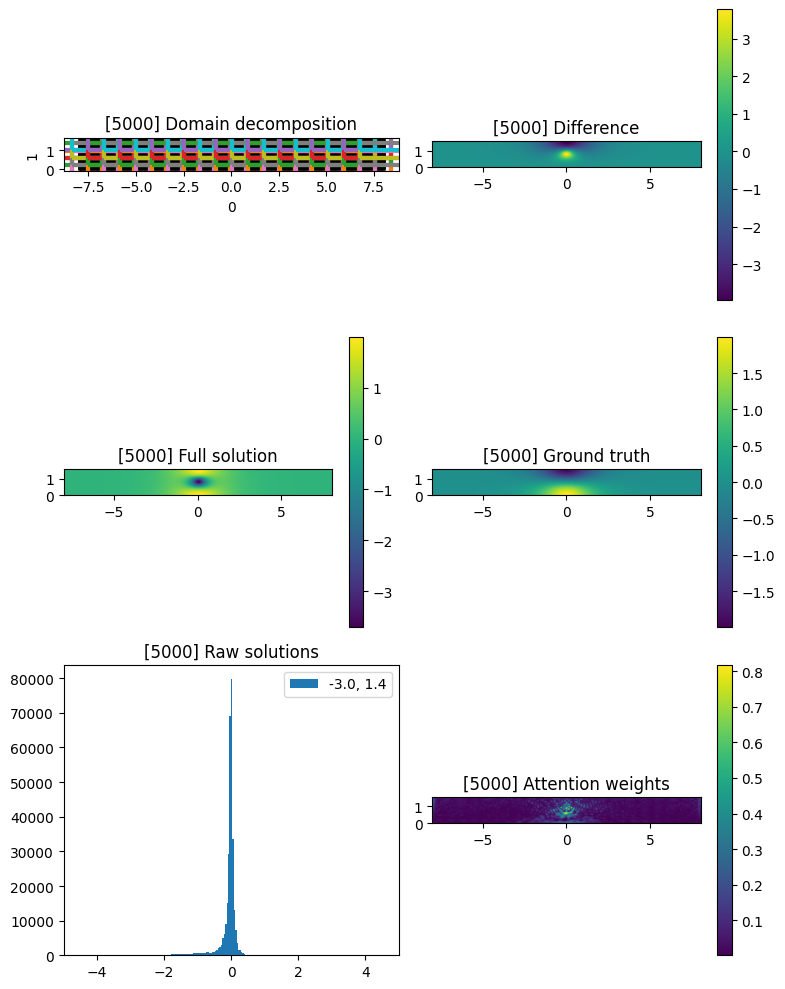

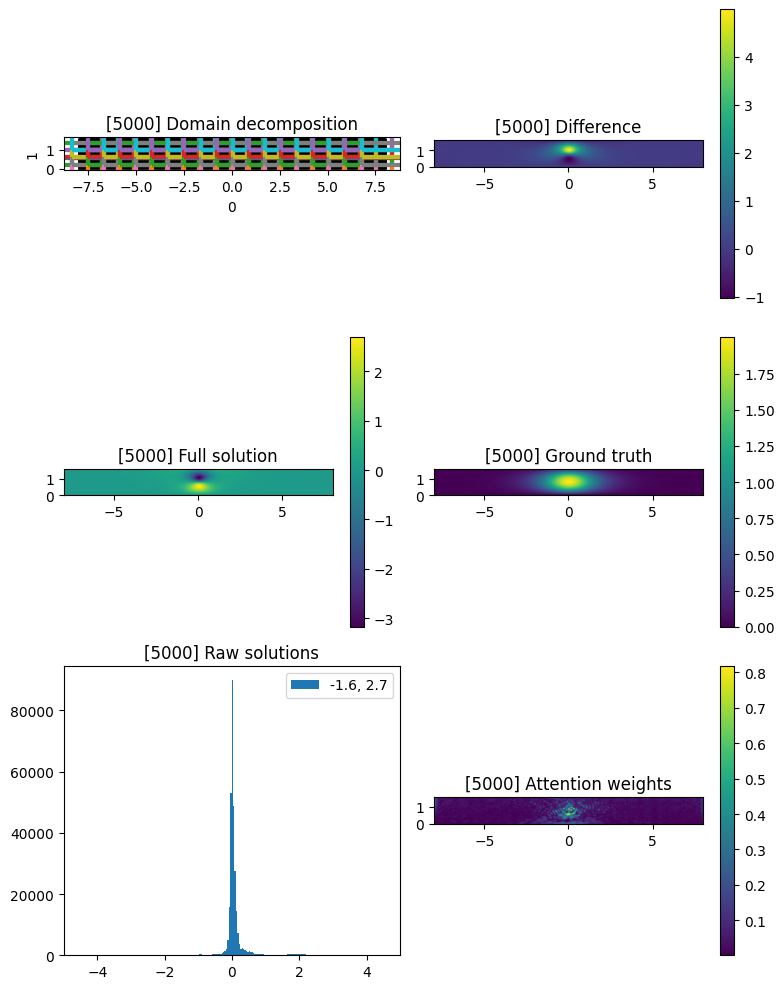

[INFO] 2025-06-05 15:29:15 - [i: 6000/50000] loss: 0.0007 rate: 58.7 elapsed: 0.03 hr test
[INFO] 2025-06-05 15:29:32 - [i: 7000/50000] loss: 0.0007 rate: 58.4 elapsed: 0.03 hr test
[INFO] 2025-06-05 15:29:49 - [i: 8000/50000] loss: 0.0007 rate: 58.2 elapsed: 0.04 hr test
[INFO] 2025-06-05 15:30:06 - [i: 9000/50000] loss: 0.0004 rate: 58.4 elapsed: 0.04 hr test
[INFO] 2025-06-05 15:30:24 - [i: 10000/50000] loss: 0.0003 rate: 58.3 elapsed: 0.05 hr test
[INFO] 2025-06-05 15:30:24 - saved arrays
[INFO] 2025-06-05 15:30:24 - saved arrays


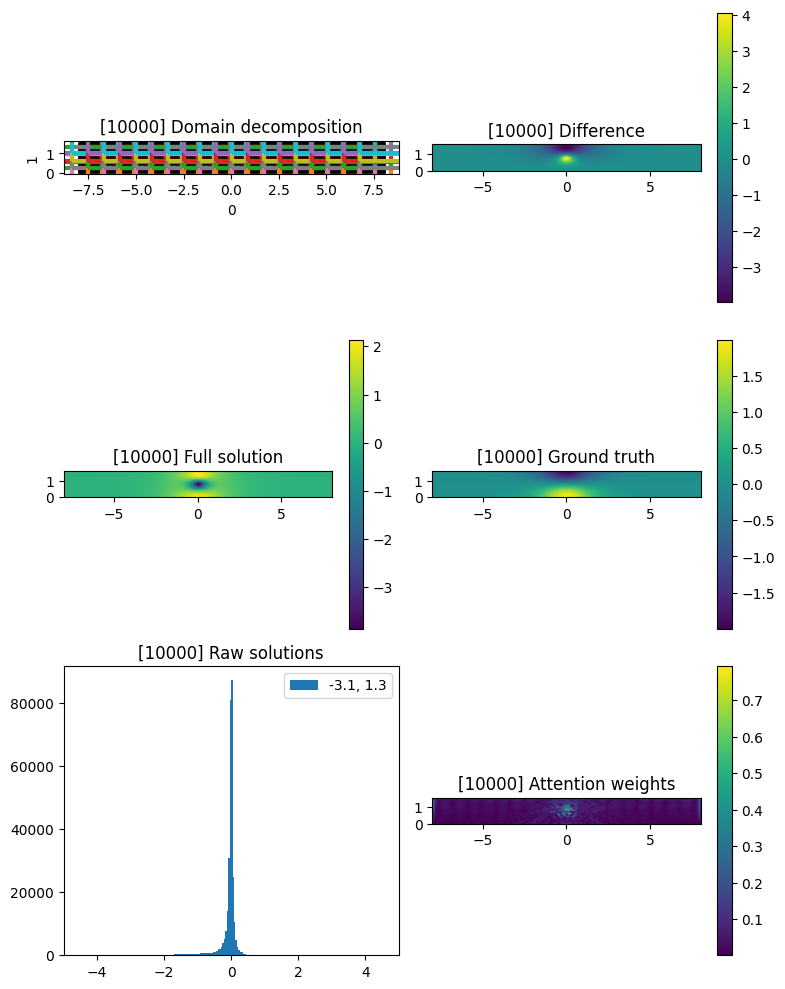

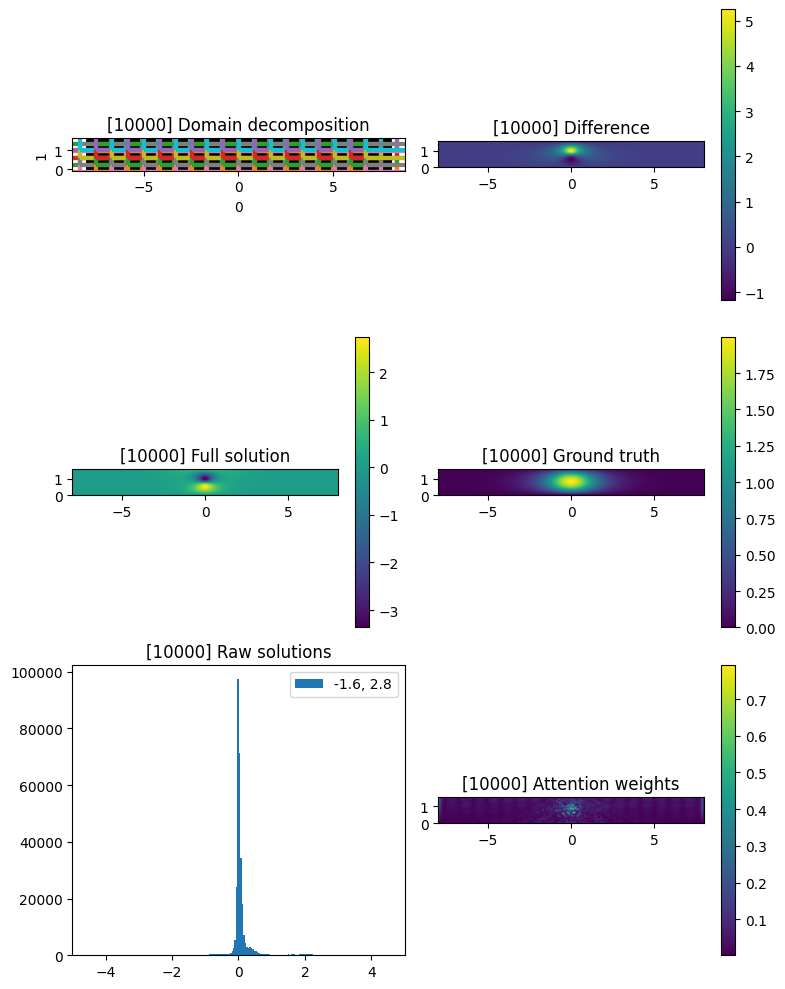

[INFO] 2025-06-05 15:30:42 - [i: 11000/50000] loss: 0.0003 rate: 58.3 elapsed: 0.05 hr test
[INFO] 2025-06-05 15:30:59 - [i: 12000/50000] loss: 0.0003 rate: 58.3 elapsed: 0.06 hr test
[INFO] 2025-06-05 15:31:17 - [i: 13000/50000] loss: 0.0005 rate: 58.2 elapsed: 0.06 hr test
[INFO] 2025-06-05 15:31:34 - [i: 14000/50000] loss: 0.0003 rate: 58.5 elapsed: 0.07 hr test
[INFO] 2025-06-05 15:31:51 - [i: 15000/50000] loss: 0.0003 rate: 58.3 elapsed: 0.07 hr test
[INFO] 2025-06-05 15:31:51 - saved arrays
[INFO] 2025-06-05 15:31:51 - saved arrays


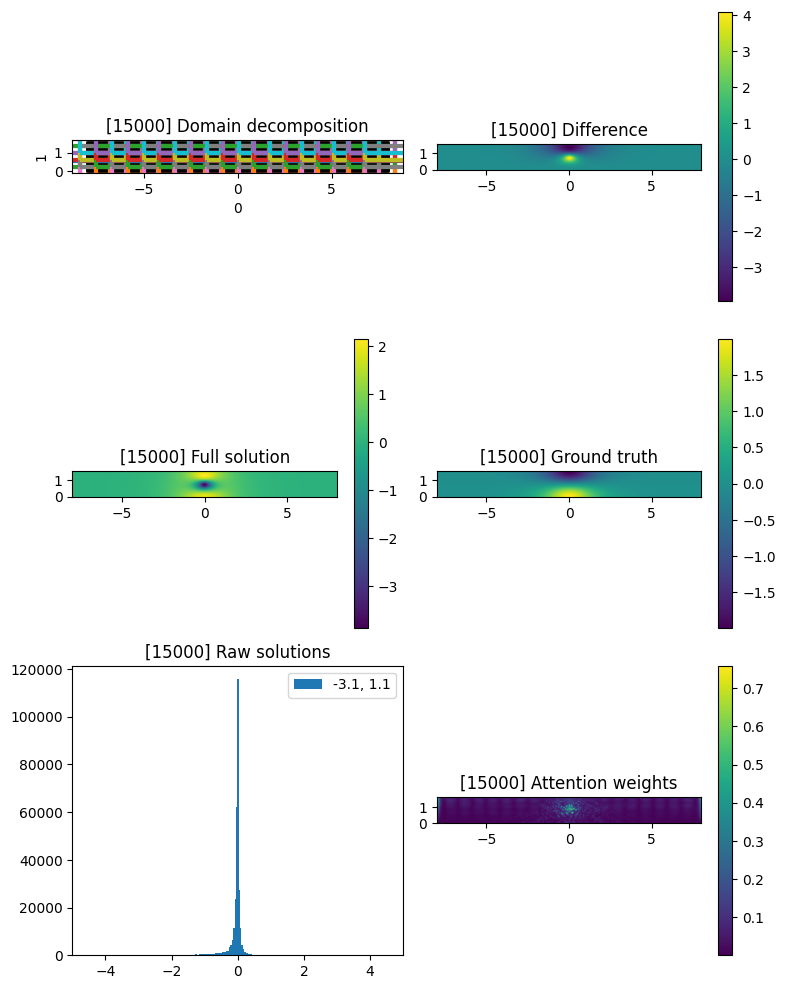

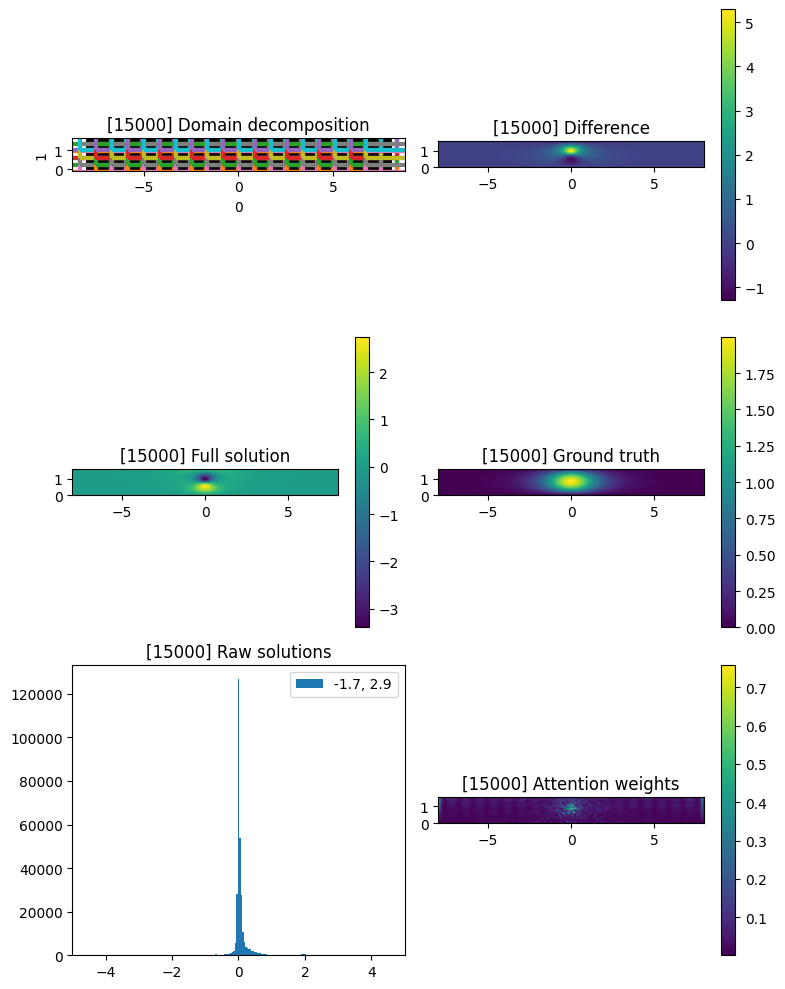

[INFO] 2025-06-05 15:32:09 - [i: 16000/50000] loss: 0.0004 rate: 58.2 elapsed: 0.08 hr test
[INFO] 2025-06-05 15:32:27 - [i: 17000/50000] loss: 0.0003 rate: 58.2 elapsed: 0.08 hr test
[INFO] 2025-06-05 15:32:44 - [i: 18000/50000] loss: 0.0003 rate: 58.3 elapsed: 0.09 hr test
[INFO] 2025-06-05 15:33:01 - [i: 19000/50000] loss: 0.0004 rate: 58.3 elapsed: 0.09 hr test
[INFO] 2025-06-05 15:33:18 - [i: 20000/50000] loss: 0.0002 rate: 58.3 elapsed: 0.10 hr test
[INFO] 2025-06-05 15:33:18 - saved arrays
[INFO] 2025-06-05 15:33:19 - saved arrays


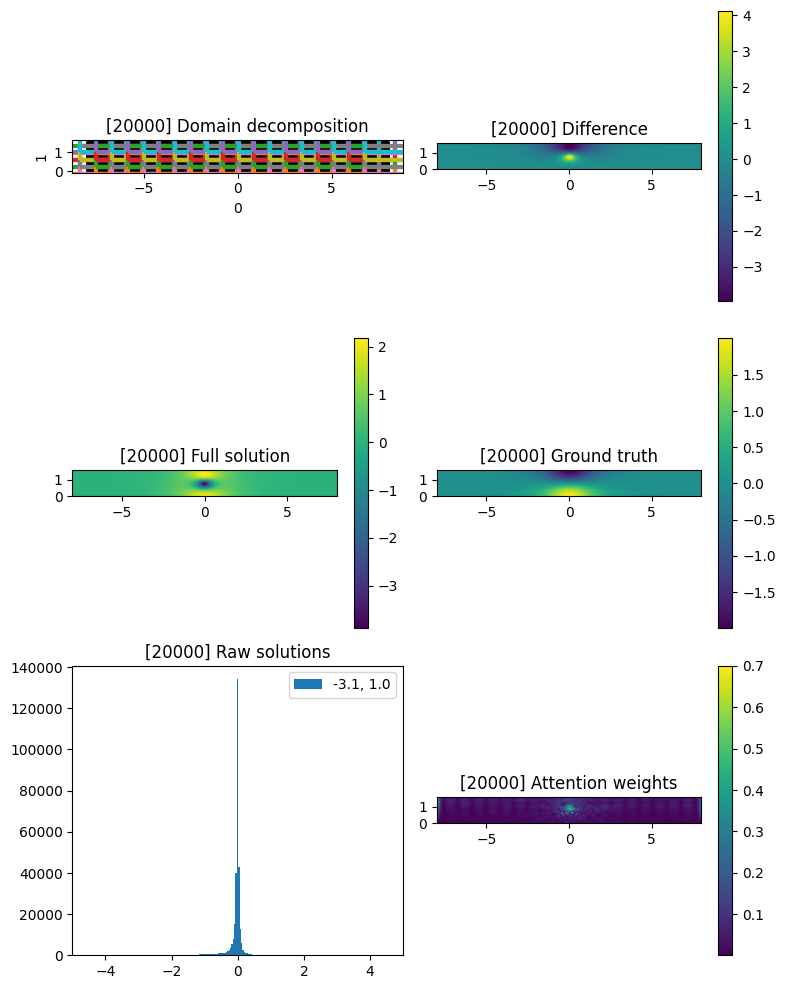

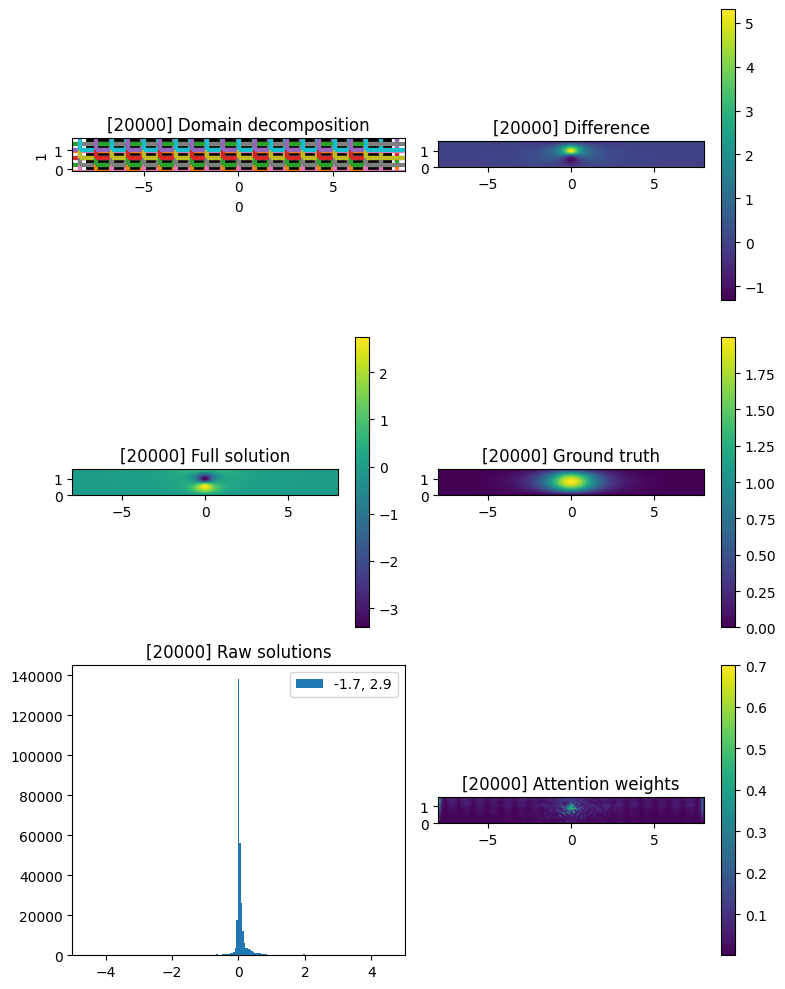

[INFO] 2025-06-05 15:33:37 - [i: 21000/50000] loss: 0.0002 rate: 58.3 elapsed: 0.10 hr test
[INFO] 2025-06-05 15:33:54 - [i: 22000/50000] loss: 0.0003 rate: 58.1 elapsed: 0.11 hr test
[INFO] 2025-06-05 15:34:11 - [i: 23000/50000] loss: 0.0003 rate: 58.2 elapsed: 0.11 hr test
[INFO] 2025-06-05 15:34:28 - [i: 24000/50000] loss: 0.0002 rate: 58.1 elapsed: 0.12 hr test
[INFO] 2025-06-05 15:34:45 - [i: 25000/50000] loss: 0.0002 rate: 58.1 elapsed: 0.12 hr test
[INFO] 2025-06-05 15:34:46 - saved arrays
[INFO] 2025-06-05 15:34:46 - saved arrays


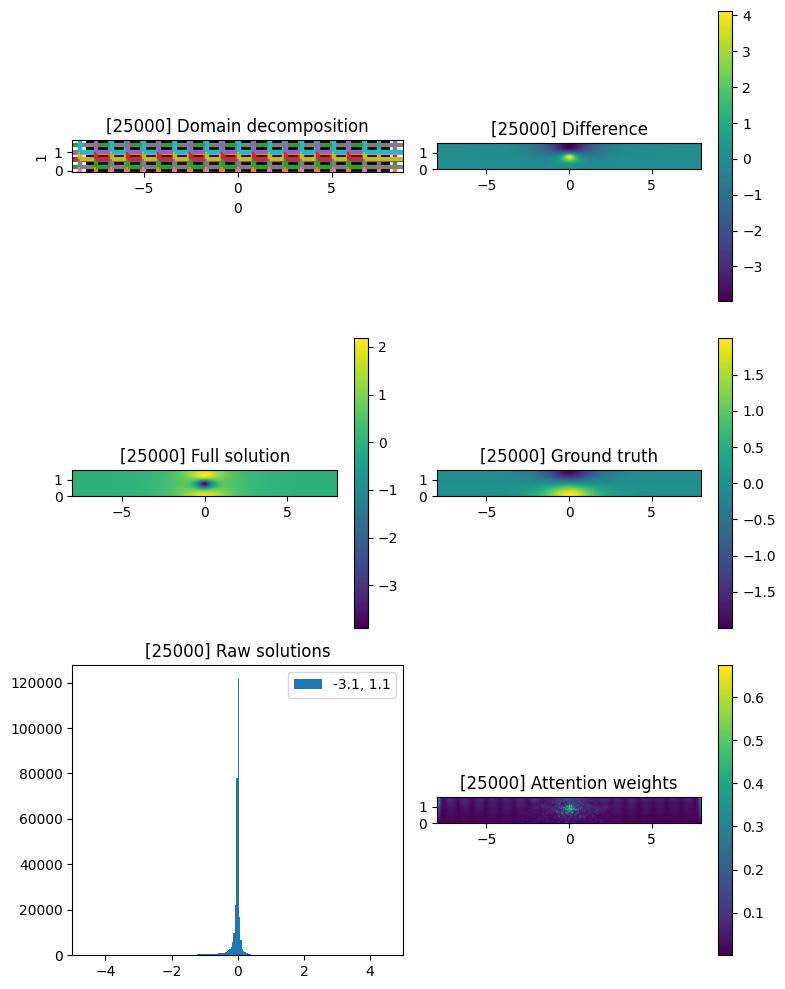

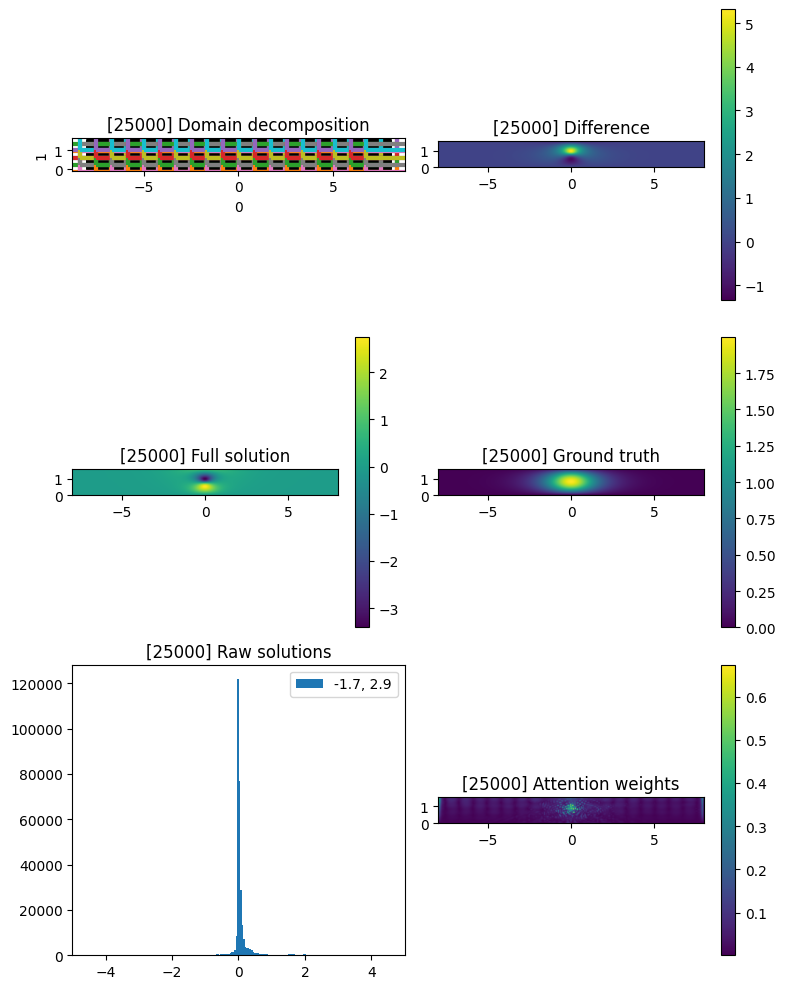

[INFO] 2025-06-05 15:35:04 - [i: 26000/50000] loss: 0.0002 rate: 58.2 elapsed: 0.13 hr test
[INFO] 2025-06-05 15:35:21 - [i: 27000/50000] loss: 0.0002 rate: 58.2 elapsed: 0.13 hr test
[INFO] 2025-06-05 15:35:39 - [i: 28000/50000] loss: 0.0002 rate: 58.2 elapsed: 0.14 hr test
[INFO] 2025-06-05 15:35:56 - [i: 29000/50000] loss: 0.0002 rate: 58.1 elapsed: 0.14 hr test
[INFO] 2025-06-05 15:36:13 - [i: 30000/50000] loss: 0.0003 rate: 58.3 elapsed: 0.15 hr test
[INFO] 2025-06-05 15:36:13 - saved arrays
[INFO] 2025-06-05 15:36:13 - saved arrays


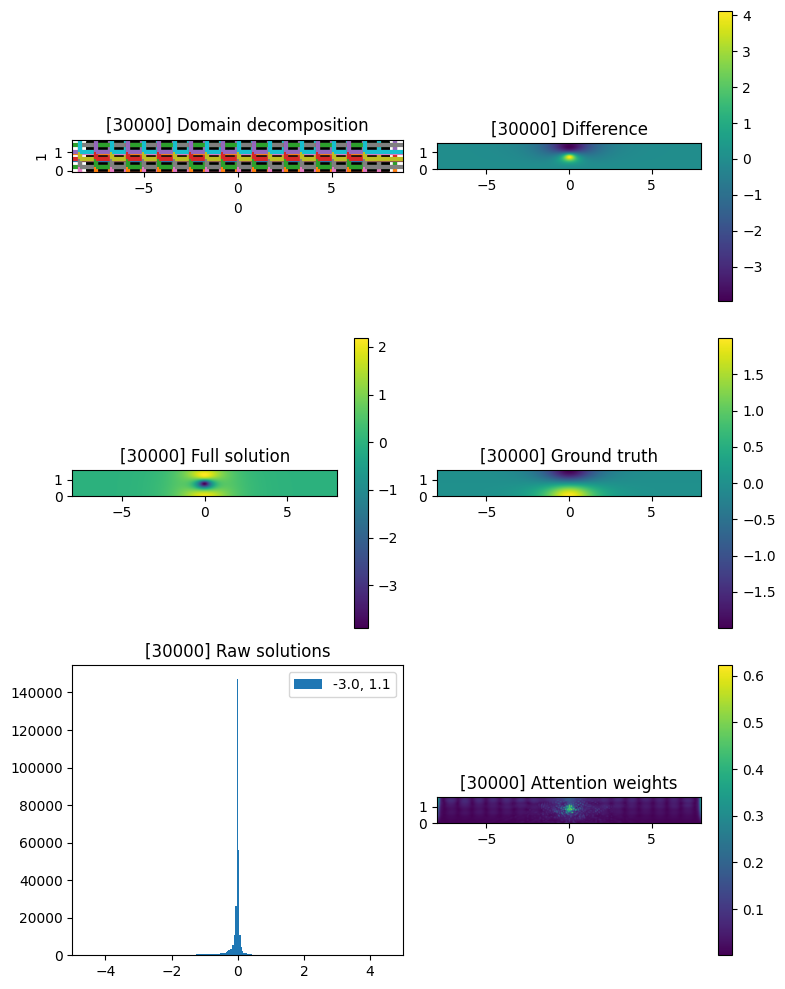

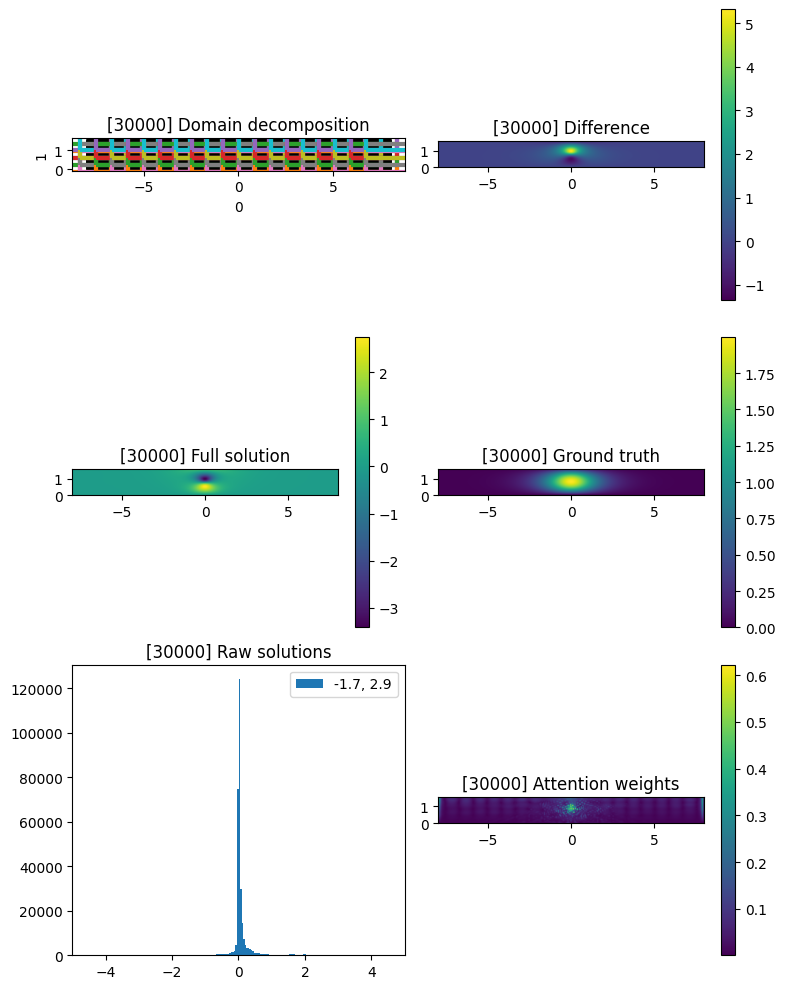

[INFO] 2025-06-05 15:36:31 - [i: 31000/50000] loss: 0.0002 rate: 59.0 elapsed: 0.15 hr test
[INFO] 2025-06-05 15:36:48 - [i: 32000/50000] loss: 0.0002 rate: 59.1 elapsed: 0.16 hr test
[INFO] 2025-06-05 15:37:05 - [i: 33000/50000] loss: 0.0003 rate: 58.6 elapsed: 0.16 hr test
[INFO] 2025-06-05 15:37:22 - [i: 34000/50000] loss: 0.0002 rate: 58.3 elapsed: 0.17 hr test
[INFO] 2025-06-05 15:37:40 - [i: 35000/50000] loss: 0.0003 rate: 58.2 elapsed: 0.17 hr test
[INFO] 2025-06-05 15:37:40 - saved arrays
[INFO] 2025-06-05 15:37:40 - saved arrays


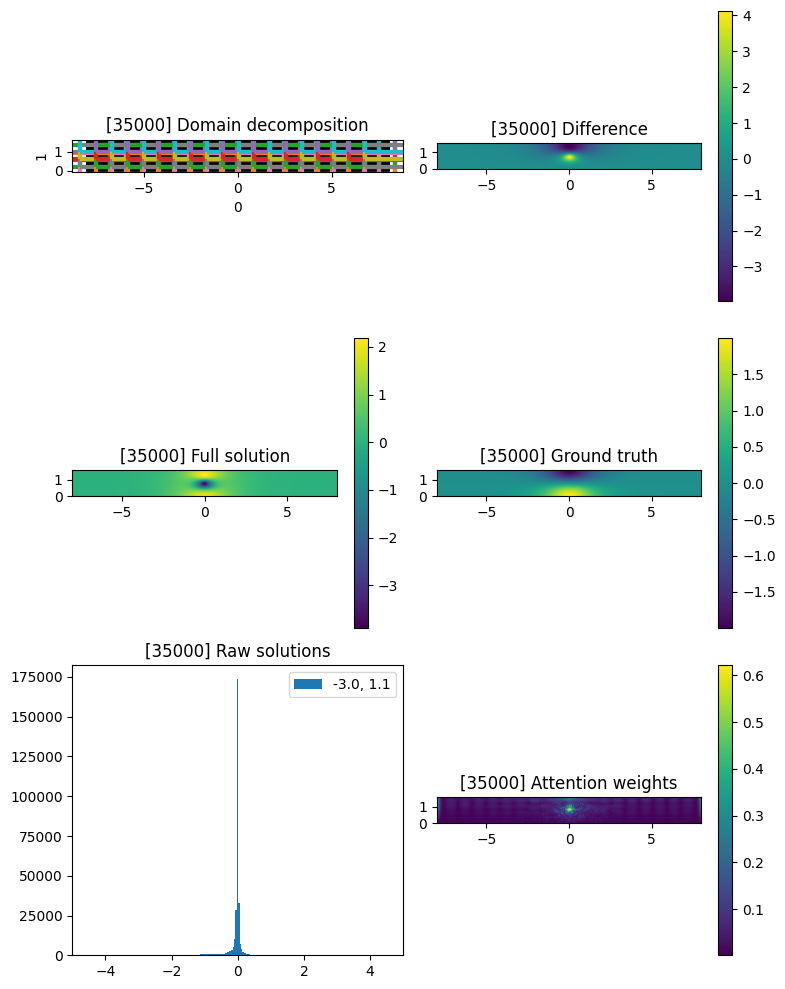

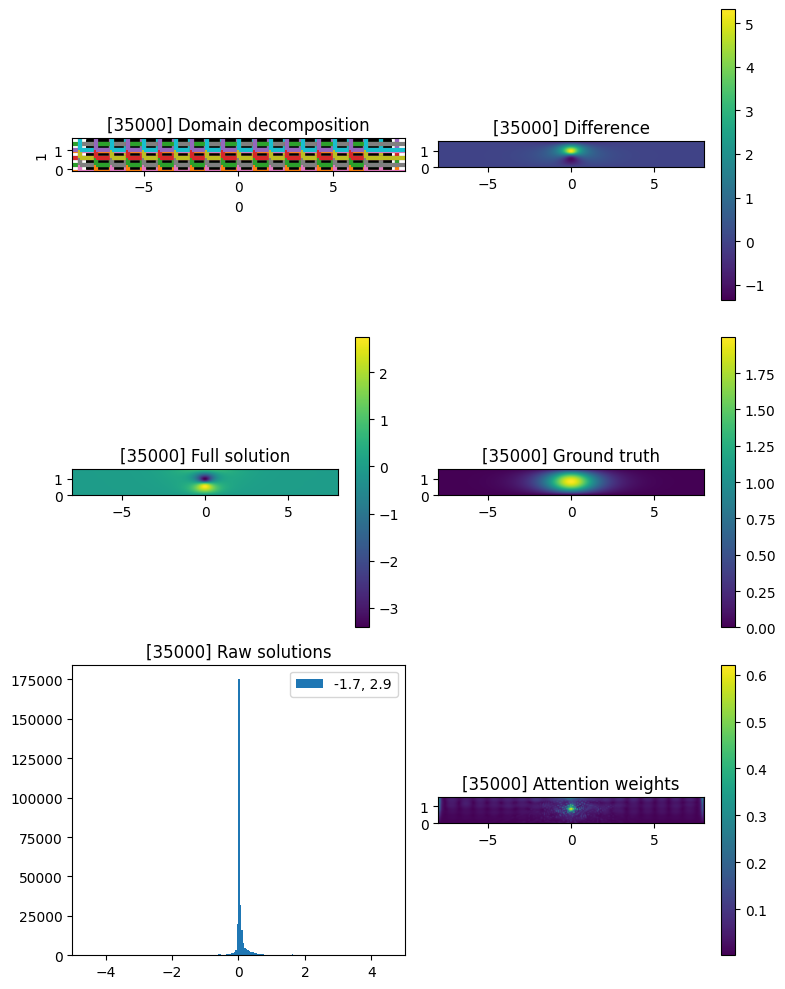

[INFO] 2025-06-05 15:37:58 - [i: 36000/50000] loss: 0.0002 rate: 58.2 elapsed: 0.18 hr test
[INFO] 2025-06-05 15:38:15 - [i: 37000/50000] loss: 0.0002 rate: 58.3 elapsed: 0.18 hr test
[INFO] 2025-06-05 15:38:33 - [i: 38000/50000] loss: 0.0002 rate: 58.3 elapsed: 0.19 hr test
[INFO] 2025-06-05 15:38:50 - [i: 39000/50000] loss: 0.0002 rate: 58.2 elapsed: 0.19 hr test
[INFO] 2025-06-05 15:39:07 - [i: 40000/50000] loss: 0.0001 rate: 58.3 elapsed: 0.19 hr test
[INFO] 2025-06-05 15:39:07 - saved arrays
[INFO] 2025-06-05 15:39:07 - saved arrays


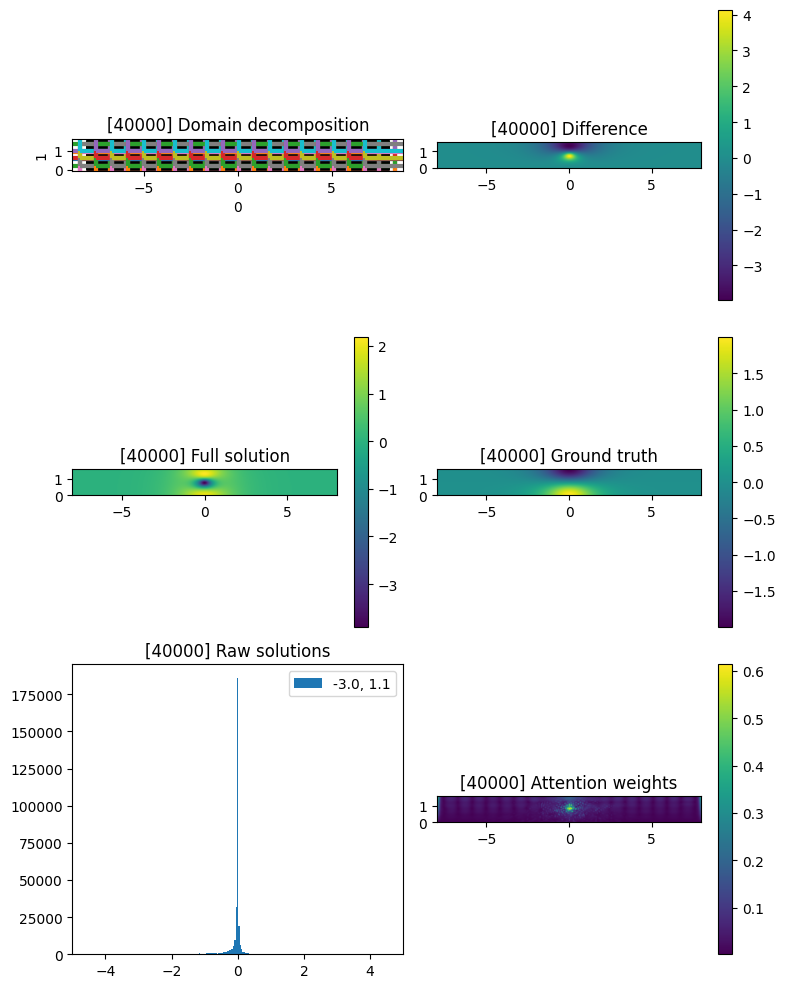

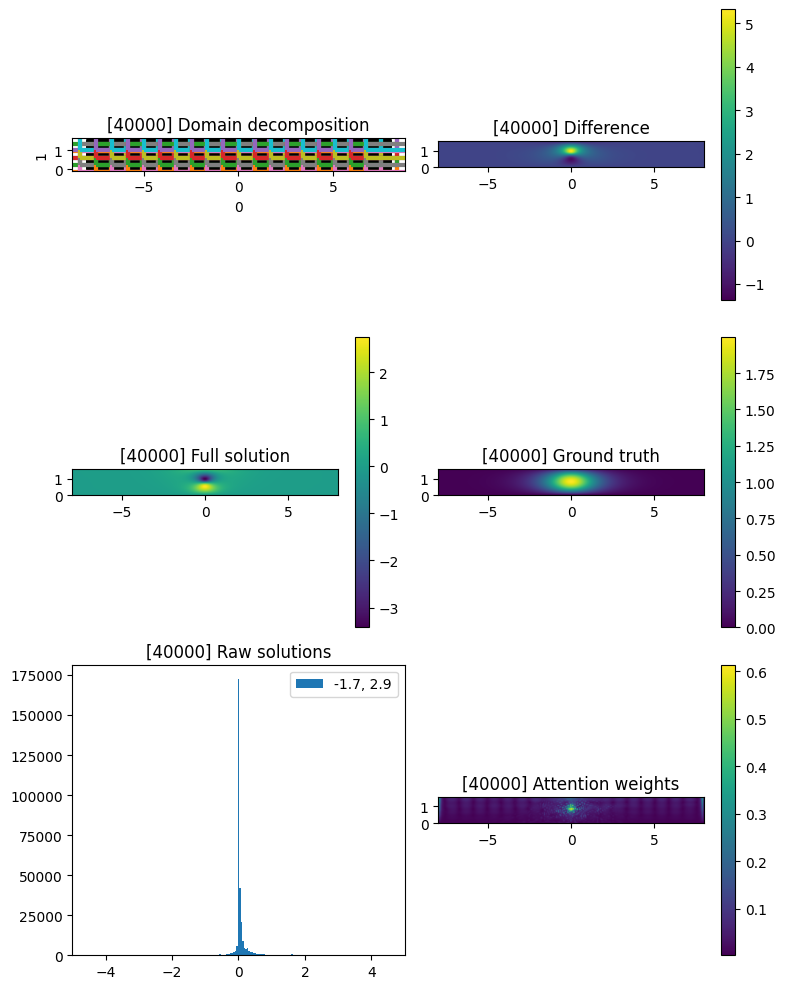

[INFO] 2025-06-05 15:39:25 - [i: 41000/50000] loss: 0.0003 rate: 58.2 elapsed: 0.20 hr test
[INFO] 2025-06-05 15:39:42 - [i: 42000/50000] loss: 0.0003 rate: 58.7 elapsed: 0.20 hr test
[INFO] 2025-06-05 15:40:00 - [i: 43000/50000] loss: 0.0002 rate: 58.5 elapsed: 0.21 hr test
[INFO] 2025-06-05 15:40:17 - [i: 44000/50000] loss: 0.0001 rate: 58.6 elapsed: 0.21 hr test
[INFO] 2025-06-05 15:40:34 - [i: 45000/50000] loss: 0.0002 rate: 58.6 elapsed: 0.22 hr test
[INFO] 2025-06-05 15:40:34 - saved arrays
[INFO] 2025-06-05 15:40:34 - saved arrays


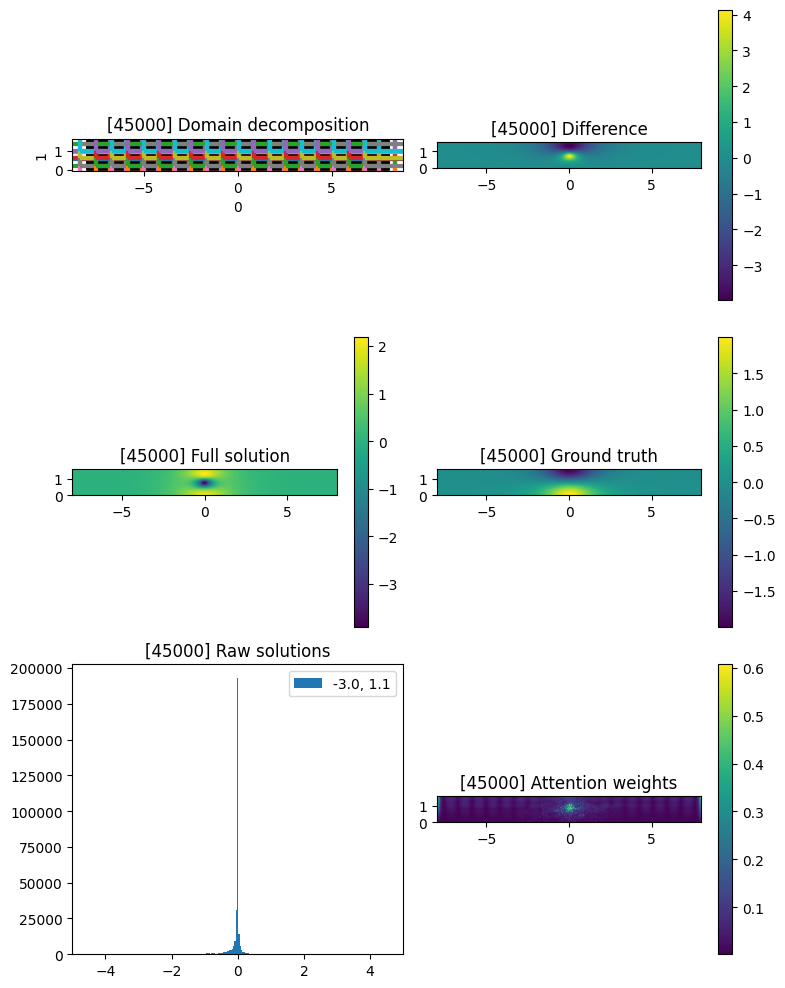

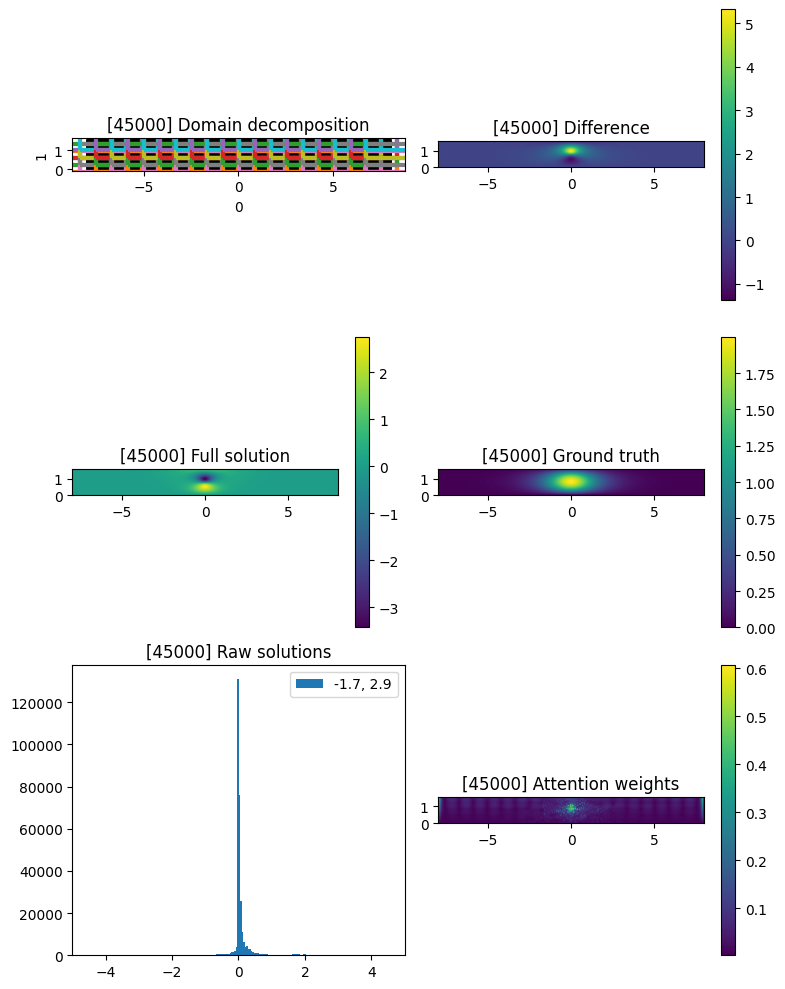

[INFO] 2025-06-05 15:40:52 - [i: 46000/50000] loss: 0.0002 rate: 58.6 elapsed: 0.22 hr test
[INFO] 2025-06-05 15:41:09 - [i: 47000/50000] loss: 0.0006 rate: 58.5 elapsed: 0.23 hr test
[INFO] 2025-06-05 15:41:26 - [i: 48000/50000] loss: 0.0001 rate: 58.5 elapsed: 0.23 hr test
[INFO] 2025-06-05 15:41:44 - [i: 49000/50000] loss: 0.0002 rate: 58.3 elapsed: 0.24 hr test
[INFO] 2025-06-05 15:42:01 - [i: 50000/50000] loss: 0.0002 rate: 58.3 elapsed: 0.24 hr test
[INFO] 2025-06-05 15:42:01 - saved arrays
[INFO] 2025-06-05 15:42:01 - saved arrays


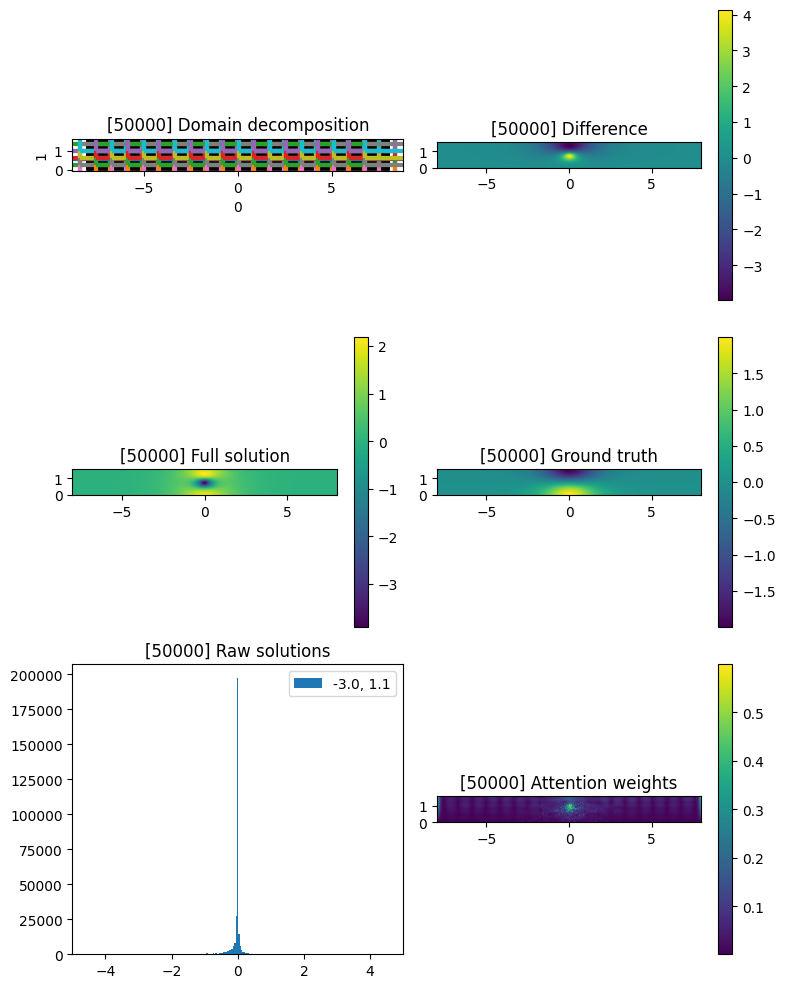

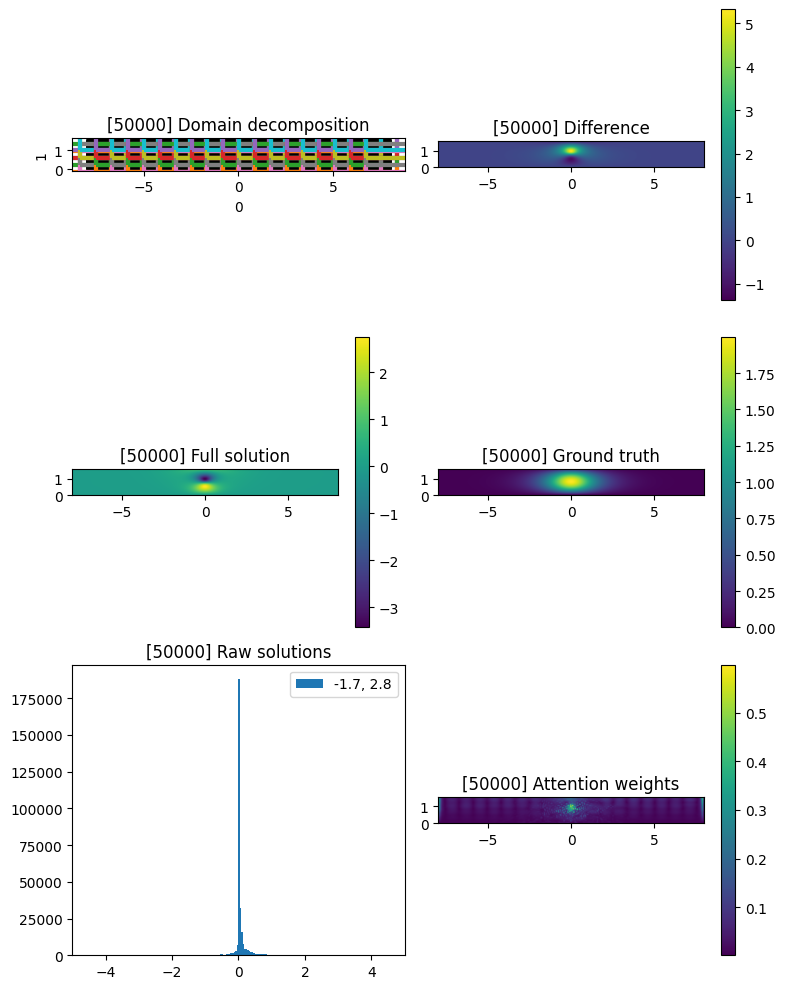

[INFO] 2025-06-05 15:42:02 - [i: 50000/50000] Training complete
[INFO] 2025-06-05 15:42:02 - [i: 50000/50000] Total training time: 875.68 s


In [6]:
import numpy as np

from fbpinns.domains import RectangularDomainND
from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.networks import FCN, ChebyshevKAN, LegendreKAN, StackedChebyshevKAN
from fbpinns.schedulers import LineSchedulerRectangularND
from fbpinns.constants import Constants, get_subdomain_ws
from fbpinns.trainers import FBPINNTrainer
from fbpinns.problems import Schrodinger1D_Non_Stationary

L = 8.
x_min, x_max = -L, L
t_min, t_max = 0., jnp.pi/2
subdomain_xs=[np.linspace(x_min, x_max, 20), np.linspace(t_min, t_max, 5)]
c = Constants(
    domain=RectangularDomainND,
    domain_init_kwargs = dict(
        xmin=np.array([x_min,t_min]),
        xmax=np.array([x_max,t_max])
        ),
    problem=Schrodinger1D_,
    problem_init_kwargs = dict(
        L=L,
    ),
    decomposition=RectangularDecompositionND,
    decomposition_init_kwargs=dict(
        subdomain_xs=subdomain_xs,
        subdomain_ws=get_subdomain_ws(subdomain_xs, 2.9),
        unnorm=(0.,3.),
    ),
    # network=FCN,
    # network_init_kwargs = dict(
    #     layer_sizes = (2, 32, 2),
    # ),
    # network=ChebyshevKAN,
    network=StackedChebyshevKAN,# place a fully-connected network in each subdomain
    network_init_kwargs=dict(
        dims=[2, 4, 2],
        degrees=[4, 4]
    ),
    # scheduler = LineSchedulerRectangularND,
    # scheduler_kwargs = dict(
    #     point=[0.], iaxis=0,
    # ),
    optimiser_kwargs = dict(
        learning_rate=0.001
        ),
    ns=((400,100),),
    n_test=(400,100),
    n_steps=50000,
    clear_output=False,
    attention_tracking_kwargs=dict(
        eta_lr=1e-2,
        gamma_decay=0.99,
        shape=(40000, 1)
    )
)

run = FBPINNTrainer(c)
all_params = run.train()